# Alex Sessums & Valentin Lorenzen

In [743]:
# Data Analysis
import numpy as np
import pandas as pd
# Miscellaneous
from itertools import chain,cycle
from IPython.display import display, HTML
import os
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)
import matplotlib.ticker as mtick
sns.set_style("dark")


In [744]:
# Load Data from Text File into Dataframe
days = ['friday','thursday','wednesday','tuesday','monday']

df = pd.DataFrame()

for day in days:
    df = pd.concat([pd.read_csv(f'data/{day}.csv', sep=';'), df])

In [745]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['customer_no'] = df['customer_no'].astype(int)
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day

In [746]:
df.loc[df.day==3,'customer_no']+=2000
df.loc[df.day==4,'customer_no']+=4000
df.loc[df.day==5,'customer_no']+=6000
df.loc[df.day==6,'customer_no']+=8000

In [747]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

### Calculate the time each customer spent in the market

In [748]:
total_customer_time = pd.DataFrame()

total_customer_time['total_time_spend'] = df.groupby('customer_no').last()['timestamp'] - df.groupby('customer_no').first()['timestamp']

for row in total_customer_time.iterrows():
    if row[1][0] == pd.Timedelta("0 days 00:00:00"):
        if row[0] < 2000:
            total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-02 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]
        if row[0] < 4000:
            total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-03 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]
        if row[0] < 6000:
            total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-04 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]
        if row[0] < 8000:
            total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-05 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]
        if row[0] > 8000:
            total_customer_time['total_time_spend'][row[0]] = pd.to_datetime("2019-09-06 22:00:00") - df.groupby('customer_no').first()['timestamp'][row[0]]    

total_customer_time['minutes'] = total_customer_time['total_time_spend'].dt.total_seconds()/60
total_customer_time['minutes'] = total_customer_time['minutes'].astype(int)

# Print spent time for n customer
def print_customer_spent_time (customer_no):
    try:       
        print ('Customer #', customer_no, 'stayed for', total_customer_time['minutes'][customer_no], 'minutes')
    except:
        print ('Customer not in database')


print_customer_spent_time(99)
print_customer_spent_time(1298)
print_customer_spent_time(1)
print_customer_spent_time(5198)


Customer # 99 stayed for 7 minutes
Customer # 1298 stayed for 1 minutes
Customer # 1 stayed for 2 minutes
Customer # 5198 stayed for 2 minutes


In [749]:
# Create minute - groups

minute_groups = []

for x in total_customer_time['minutes']:
    if x <= 5:
        minute_groups.append("1 - 5 Minutes")
    elif x <=10:
        minute_groups.append("6 - 10 Minutes")
    elif x <=15:
        minute_groups.append("11 - 15 Minutes")
    elif x <=20:
        minute_groups.append("16 - 20 Minutes")
    elif x > 20:
        minute_groups.append("Longer than 20 minutes")

total_customer_time['minutes_groups'] = minute_groups

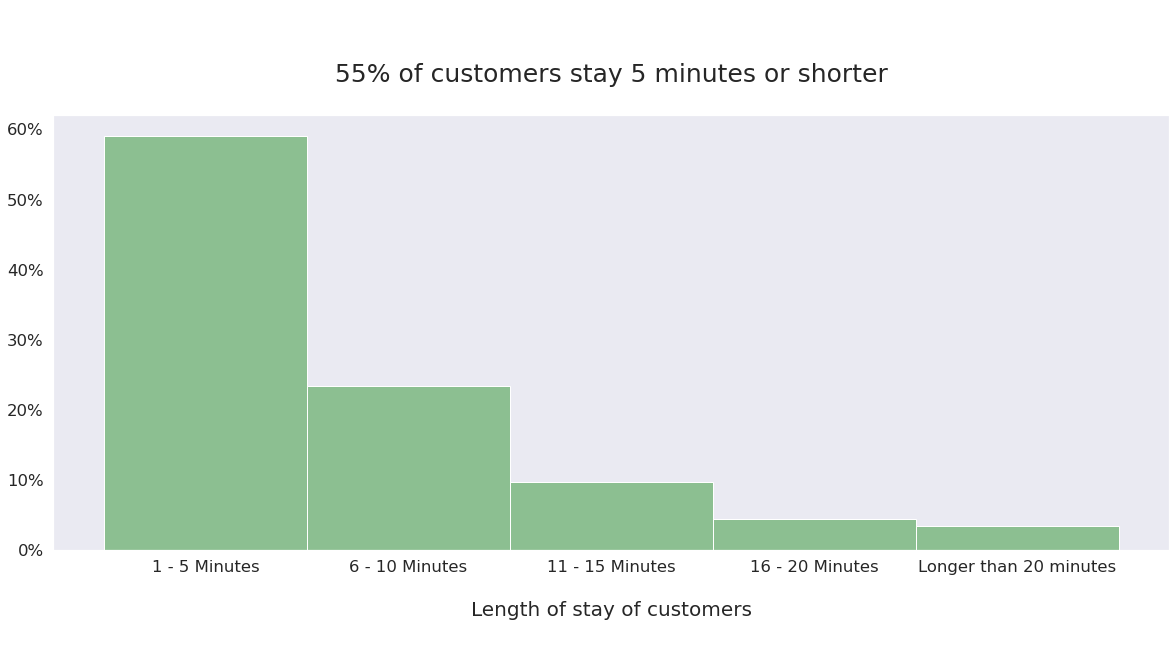

In [750]:
# Graph 4
# Calculate the time each customer spent in the market

fig = plt.gcf()
fig.set_size_inches(20,8)
total_customer_time['minutes_groups'] = pd.Categorical(total_customer_time['minutes_groups'], ['1 - 5 Minutes','6 - 10 Minutes','11 - 15 Minutes','16 - 20 Minutes', 'Longer than 20 minutes'])
p = sns.histplot(data=total_customer_time['minutes_groups'].sort_values(), stat='percent', color="green", alpha=0.4)
p.yaxis.set_major_formatter(mtick.PercentFormatter())
p.set_xlabel("\nLength of stay of customers\n\n", fontsize = 20)
p.set_ylabel("")
p.set_title("\n\n55% of customers stay 5 minutes or shorter\n", fontsize = 25);

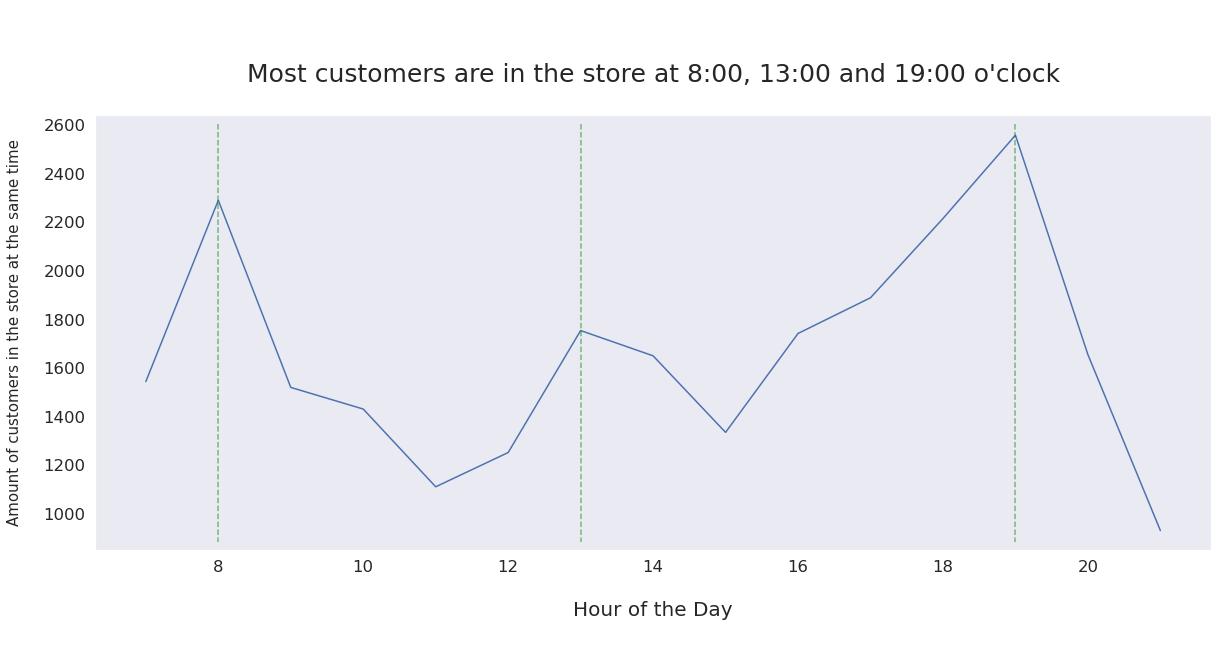

In [751]:
# Graph 5
# Calculate the total number of customers in the supermarket over time.

fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.lineplot(x=df['hour'].unique(), y=df.groupby('hour')['customer_no'].count())
p.set_xlabel("\nHour of the Day\n", fontsize = 20)
p.set_ylabel("Amount of customers in the store at the same time\n", fontsize = 15)
line1 = plt.axvline(8, 0.98,0.02, color='green', linestyle="--", alpha=0.5)
line3 = plt.axvline(13,0.98,0.02, color='green', linestyle="--", alpha=0.5)
line4 = plt.axvline(19,0.98,0.02, color='green', linestyle="--", alpha=0.5)
p.set_title("\n\nMost customers are in the store at 8:00, 13:00 and 19:00 o'clock\n", fontsize = 25);

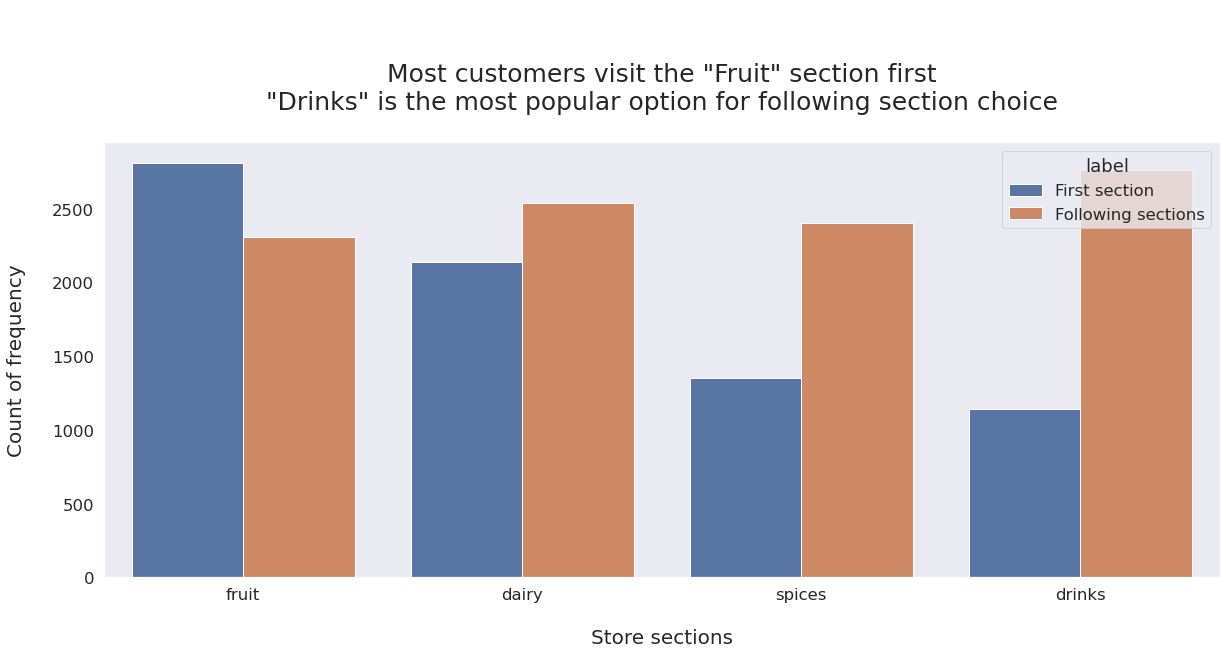

In [752]:
# Graph 6
# Our business managers think that the first section customers visit follows a different pattern than the following ones.
# Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

first_section_vc = df.groupby('customer_no').first()['location'].value_counts()
following_section_vc = df['location'].value_counts() - first_section_vc
following_section_vc.drop('checkout', inplace=True)
first_section_vc = pd.DataFrame(first_section_vc, columns=["location", "customers"]).reset_index(level=0)
first_section_vc.columns = ['location', 'customers', 'label']
first_section_vc['label'] = 'First section'
following_section_vc = pd.DataFrame(following_section_vc, columns=["location", "customers"]).reset_index(level=0)
following_section_vc.columns = ['location', 'customers', 'label']
following_section_vc['label'] = 'Following sections'
all_section_vs = pd.concat([first_section_vc, following_section_vc])
fig = plt.gcf()
fig.set_size_inches(20,8)
p = sns.barplot(x="location", y="customers", hue="label", data=all_section_vs)
p.set_xlabel("\nStore sections", fontsize = 20)
p.set_ylabel("Count of frequency\n", fontsize = 20)
p.set_title('\n\nMost customers visit the "Fruit" section first\n"Drinks" is the most popular option for following section choice\n', fontsize = 25);

## Creating 'path' - feature

In [753]:
df['minute'] = df['timestamp'].dt.minute
customer_path_diff = pd.DataFrame(columns=['customer_no', 'path'])
locations = {'dairy': 'd', 'drinks': 'k', 'fruit': 'f', 'spices': 's'}
customer_path_diff['path'] = df.sort_values(['customer_no', 'timestamp']).apply(lambda x: locations.get(x.location), axis=1)

In [754]:
customer_path_diff['customer_no'] = df.sort_values(['customer_no', 'timestamp'])['customer_no']

In [755]:
customer_path_diff['diff'] = df.groupby('customer_no')['timestamp'].diff().astype('timedelta64[m]')
customer_path_diff['diff'] = customer_path_diff['diff'].shift(-1)
customer_path_diff['diff'] = customer_path_diff['diff'].fillna(0)
customer_path_diff['diff'] = customer_path_diff['diff'].astype(int)

In [756]:
customer_path_diff['path_mult'] = customer_path_diff['path'] * customer_path_diff['diff']

In [757]:
customer_path_diff.dropna(inplace=True)
customer_path_diff['path_mult'] = customer_path_diff['path_mult'].astype(str)


In [758]:
customer_paths = pd.DataFrame()

In [759]:
customer_paths['paths'] = customer_path_diff.groupby('customer_no')['path_mult'].sum()

In [760]:
customers = set(df['customer_no'])
customers_checkout = set(df['customer_no'].loc[df['location']=='checkout'])
customers_nocheckout = customers - customers_checkout

In [761]:
from datetime import datetime, date

for customer in customers_nocheckout:
        time_checkout = df.groupby('customer_no').last()['timestamp'][customer].time()
        time_force_checkout = datetime.strptime('21:50:01', '%H:%M:%S').time()
        duration = datetime.combine(date.min, time_force_checkout) - datetime.combine(date.min, time_checkout)
        duration = int(duration.total_seconds()/60)
        try:
            customer_paths['paths'][customer] += duration * customer_paths['paths'][customer][-1]
        except:
            pass

In [762]:
customer_paths['paths'] = customer_paths['paths'].apply(lambda x: 'e' + x + 'c')

## Markov

In [763]:
customer_paths['location'] = customer_paths['paths'].apply(lambda x: list(x))

In [764]:
customer_paths = customer_paths.explode('location')

In [765]:
customer_paths['next_location'] = customer_paths.groupby(['customer_no'])['location'].shift(-1)

In [766]:
customer_paths['next_location'].fillna('c', inplace=True)

In [767]:
customer_just_paths = customer_paths['paths']

In [768]:
df.groupby('location')[['customer_no']].nunique().reset_index()

,location,customer_no
0,checkout,7417
1,dairy,3818
2,drinks,3214
3,fruit,4284
4,spices,2938


In [769]:
trans_matrix = customer_paths.groupby('location')['next_location'].value_counts(normalize=True).unstack()

In [770]:
trans_matrix['e'] = 0

In [771]:
trans_matrix.fillna(0)

next_location,c,d,f,k,s,e
location,,,,,,
c,1.000000,0.000000,0.000000,0.000000,0.000000,0
d,0.102916,0.737361,0.049769,0.058552,0.051402,0
e,0.001209,0.286904,0.377166,0.153392,0.181330,0
f,0.201589,0.095444,0.597529,0.054843,0.050594,0
k,0.215886,0.010892,0.087649,0.598952,0.086621,0
s,0.150454,0.192644,0.090750,0.163031,0.403121,0


In [772]:
trans_matrix.index = ['checkout', 'dairy', 'entry', 'fruit', 'drinks', 'spices']

In [773]:
trans_matrix.columns = ['checkout', 'dairy', 'fruit', 'drinks', 'spices', 'entry']

In [774]:
trans_matrix_final = pd.DataFrame()

trans_matrix_final[['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout']] = trans_matrix[['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout']]

In [775]:
trans_matrix_final = trans_matrix_final.reindex(['entry', 'dairy', 'fruit', 'drinks', 'spices', 'checkout'])

In [776]:
trans_matrix_final.fillna(0, inplace=True)

In [777]:
trans_matrix_final.to_csv('data/trans_matrix.csv')

## Make visitors per minute matrix

In [778]:
df.loc[df['day']== 2].loc[df['hour'] == 7].groupby('customer_no').first().sort_index()

,timestamp,location,hour,day,minute
customer_no,,,,,
1,2019-09-02 07:03:00,dairy,7,2,3
2,2019-09-02 07:03:00,dairy,7,2,3
3,2019-09-02 07:04:00,dairy,7,2,4
4,2019-09-02 07:04:00,dairy,7,2,4
5,2019-09-02 07:04:00,spices,7,2,4
...,...,...,...,...,...
98,2019-09-02 07:56:00,dairy,7,2,56
99,2019-09-02 07:56:00,dairy,7,2,56
100,2019-09-02 07:56:00,drinks,7,2,56


In [781]:
new_visitors_per_hour = pd.DataFrame()

for i in range(7,22,1):
    new_visitors_per_hour = new_visitors_per_hour.append(df.loc[df['day']== 2].loc[df['hour'] == i].groupby('customer_no').first().sort_index())

new_visitors_per_hour = new_visitors_per_hour.groupby(['hour','minute']).count().drop(['location', 'day'], axis=1)

In [782]:
new_visitors_per_hour.columns = ['cu_amount']

In [783]:
new_visitors_per_hour.reset_index(inplace=True)

In [784]:
for hour in range(7,22,1):
    for minute in range(1,60,1):
        if new_visitors_per_hour.loc[(new_visitors_per_hour['hour']==hour) & (new_visitors_per_hour['minute']==minute)].empty:
            new_row = {'hour': hour, 'minute': minute, 'cu_amount': 0}
            new_visitors_per_hour = new_visitors_per_hour.append(new_row, ignore_index=True)
        else:
            pass

In [785]:
new_visitors_per_minute = new_visitors_per_hour.groupby('hour')['cu_amount'].value_counts(normalize=True).sort_index()

In [786]:
new_customers = pd.DataFrame(columns=[i for i in range(21)])

In [787]:
new_customers=new_customers.rename(columns = {0:'hour'})

In [788]:
new_visitors_per_minute = pd.DataFrame(new_visitors_per_minute)

In [789]:
new_visitors_per_minute.columns = ['perc']

In [790]:
new_visitors_per_minute.reset_index(inplace=True)

In [791]:
new_visitors_per_minute = new_visitors_per_minute.pivot(index='hour', columns='cu_amount', values='perc').fillna(0)

In [792]:
new_visitors_per_minute.to_csv('data/new_visitors_per_minute.csv')